In [2]:
import csv
import pandas as pd
from datetime import datetime
from Levenshtein import distance as levenshtein_distance
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statistics
from fitter import Fitter
import itertools
import multiprocessing
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression


In [3]:
events_final = pd.read_csv('events_final.csv') 
print(events_final)

        patientid             events            starttime
0        10002013              CSURG  2160-05-18 01:49:32
1        10002013                ABG  2160-05-18 09:19:00
2        10002013            Calcium  2160-05-18 09:19:00
3        10002013            Glucose  2160-05-18 09:19:00
4        10002013                CBC  2160-05-18 09:19:00
...           ...                ...                  ...
127841   19995790  Magnesium Sulfate  2185-02-05 01:00:00
127842   19995790         Metoprolol  2185-02-05 20:00:00
127843   19995790  Magnesium Sulfate  2185-02-06 02:00:00
127844   19995790       Electrolytes  2185-02-06 06:00:00
127845   19995790         Metoprolol  2185-02-06 20:00:00

[127846 rows x 3 columns]


In [4]:
events_final['starttime'] = pd.to_datetime(events_final['starttime'])

In the next step, we will start to generat the trace

In [5]:
traces = events_final.groupby('patientid')['events'].apply(list).reset_index()
traces['starttimes'] = events_final.groupby('patientid')['starttime'].apply(list).reset_index(drop=True)

In [6]:
print(traces.head())
traces.to_csv('traces.csv', index=False)

   patientid                                             events  \
0   10002013  [CSURG, ABG, Calcium, Glucose, CBC, Electrolyt...   
1   10011398  [CSURG, ABG, Electrolytes, CBC, Glucose, Calci...   
2   10023771  [CSURG, ABG, Calcium, Glucose, CBC, Electrolyt...   
3   10033786  [CSURG, ABG, Calcium, Glucose, CBC, Electrolyt...   
4   10039688  [CSURG, ABG, Calcium, Glucose, CBC, Electrolyt...   

                                          starttimes  
0  [2160-05-18 01:49:32, 2160-05-18 09:19:00, 216...  
1  [2146-12-15 04:53:55, 2146-12-15 07:52:00, 214...  
2  [2113-08-25 03:17:43, 2113-08-25 07:29:00, 211...  
3  [2118-01-16 06:35:16, 2118-01-16 12:00:00, 211...  
4  [2147-05-31 02:31:44, 2147-05-31 07:57:00, 214...  


In [7]:
print(traces['events'].dtype)

object


In [8]:
first_line = traces.iloc[1]['events']
second_line = traces.iloc[2]['events']
print(traces.iloc[1]['events'])
print(traces.iloc[2]['events'])

['CSURG', 'ABG', 'Electrolytes', 'CBC', 'Glucose', 'Calcium', 'Electrolytes', 'ABG', 'CBC', 'Glucose', 'Aspirin', 'ABG', 'Glucose', 'CBC', 'Electrolytes', 'Acetaminophen', 'Nitroglycerin', 'Sterile Water', 'Neostigmine', 'Opioid', 'Influenza Vaccine', 'Potassium Chloride', 'Dextrose 50%', 'Magnesium Sulfate', 'PHENYLEPHrine', 'Milk of Magnesia', 'Sodium Chloride 0.9%  Flush', 'Oxycodone-Acetaminophen', '5% Dextrose', 'Pneumococcal Vaccine', 'Glycopyrrolate', 'Metoclopramide', 'Insulin', 'Propofol', 'Sodium Chloride 0.9%', 'Calcium Gluconate', 'Lactated Ringers', 'ABG', 'Electrolytes', 'CBC', 'Glucose', 'Calcium', 'CBC', 'Sodium Chloride 0.9%', 'CefazoLIN', 'CBC', 'Urea Nitrogen', 'Electrolytes', 'Creatinine', 'Bicarbonate', 'ABG', 'Calcium', 'Glucose', 'Electrolytes', 'ABG', 'Electrolytes', 'Calcium', 'Glucose', 'Ketorolac', 'ABG', 'Glucose', 'Electrolytes', 'Electrolytes', 'CBC', 'Ondansetron', 'Chlorhexidine Gluconate 0.12% Oral Rinse', 'Docusate Sodium', 'Ranitidine', 'Albumin', 'Li

In [9]:
def calculate_hamming_distance(list1, list2, pad_value=None):

    max_len = max(len(list1), len(list2))
    list1_padded = list1 + [pad_value] * (max_len - len(list1))
    list2_padded = list2 + [pad_value] * (max_len - len(list2))
    

    distance = sum(el1 != el2 for el1, el2 in zip(list1_padded, list2_padded))
    return distance

In [10]:

list1 = ['A','B','C','D']
list2 =['A','C','D']


hamming_distance_example = calculate_hamming_distance(list1, list2, pad_value='')
print(f"Hamming distance between list1 and list2: {hamming_distance_example}")

levenshtein_distance_example = levenshtein_distance(list1, list2)
print(f"levenshtein distance between list1 and list2: {levenshtein_distance_example}")

Hamming distance between list1 and list2: 3
levenshtein distance between list1 and list2: 1


In [11]:
first_line = traces.iloc[1]['events']
second_line = traces.iloc[2]['events']
print(traces.iloc[1]['events'])
print(traces.iloc[2]['events'])
print(len(traces.iloc[1]['events']))
print(len(traces.iloc[2]['events']))
hamming_distance_1_2 = calculate_hamming_distance(first_line, second_line)
levenshtein_distance_1_2 = levenshtein_distance(first_line, second_line)
print(f"Hamming distance between the first and second lines: {hamming_distance_1_2}")
print(f"Levenshtein distance between the first and second lines: {levenshtein_distance_1_2}")

['CSURG', 'ABG', 'Electrolytes', 'CBC', 'Glucose', 'Calcium', 'Electrolytes', 'ABG', 'CBC', 'Glucose', 'Aspirin', 'ABG', 'Glucose', 'CBC', 'Electrolytes', 'Acetaminophen', 'Nitroglycerin', 'Sterile Water', 'Neostigmine', 'Opioid', 'Influenza Vaccine', 'Potassium Chloride', 'Dextrose 50%', 'Magnesium Sulfate', 'PHENYLEPHrine', 'Milk of Magnesia', 'Sodium Chloride 0.9%  Flush', 'Oxycodone-Acetaminophen', '5% Dextrose', 'Pneumococcal Vaccine', 'Glycopyrrolate', 'Metoclopramide', 'Insulin', 'Propofol', 'Sodium Chloride 0.9%', 'Calcium Gluconate', 'Lactated Ringers', 'ABG', 'Electrolytes', 'CBC', 'Glucose', 'Calcium', 'CBC', 'Sodium Chloride 0.9%', 'CefazoLIN', 'CBC', 'Urea Nitrogen', 'Electrolytes', 'Creatinine', 'Bicarbonate', 'ABG', 'Calcium', 'Glucose', 'Electrolytes', 'ABG', 'Electrolytes', 'Calcium', 'Glucose', 'Ketorolac', 'ABG', 'Glucose', 'Electrolytes', 'Electrolytes', 'CBC', 'Ondansetron', 'Chlorhexidine Gluconate 0.12% Oral Rinse', 'Docusate Sodium', 'Ranitidine', 'Albumin', 'Li

In [12]:
num_elements = len(traces)
hamming_distance_matrix = pd.DataFrame(index=range(num_elements), columns=range(num_elements))

for i in range(num_elements):
    for j in range(num_elements):
        hamming_distance = calculate_hamming_distance(traces.at[i, "events"], traces.at[j, "events"])
        hamming_distance_matrix.at[i, j] = hamming_distance


print(hamming_distance_matrix)

     0    1    2    3    4    5    6    7    8    9    ...  837  838  839  \
0      0  127  124  123  142  127  131  134  132  144  ...  124  128  142   
1    127    0  128  117  149  110  137  123  112  152  ...  125  122  145   
2    124  128    0  126  141  130  142  131  127  141  ...  130  127  143   
3    123  117  126    0  144  118  133  133  112  156  ...  134  129  133   
4    142  149  141  144    0  143  145  142  149  152  ...  144  144  149   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
842  138  139  141  144  146  137  133  138  136  148  ...  137  143  138   
843  163  160  161  161  160  159  162  164  159  157  ...  161  163  162   
844  136  116  130  117  148  120  135  136  107  150  ...  135  124  137   
845  153  153  153  152  151  154  156  152  148  158  ...  151  148  152   
846  133  110  130  120  150  116  137  126  107  151  ...  129  121  141   

     840  841  842  843  844  845  846  
0    126  188  138  163  136  153 

In [13]:

hamming_row_averages = hamming_distance_matrix.mean(axis=1)
print("Hamming row averages:")
print(hamming_row_averages)

Hamming row averages:
0      150.270366
1      144.519481
2      149.517119
3      145.680047
4      160.813459
          ...    
842     157.77804
843    173.969303
844    143.244392
845    166.390791
846    142.749705
Length: 847, dtype: object


In [14]:

hamming_sorted_row_averages = hamming_row_averages.sort_values(ascending=False)

hamming_reordered_matrix = hamming_distance_matrix.loc[hamming_sorted_row_averages.index]

print("Sorted row averages (descending):")
print(hamming_sorted_row_averages)

print("Reordered Hamming distance matrix:")
print(hamming_reordered_matrix)

Sorted row averages (descending):
822     975.90791
256    691.548996
450    676.088548
304    587.145218
595     578.74026
          ...    
792    141.806375
833    141.749705
148    141.735537
563    141.566706
235    141.472255
Length: 847, dtype: object
Reordered Hamming distance matrix:
     0    1    2    3    4    5    6    7    8    9    ...  837  838  839  \
822  969  981  976  977  975  980  974  974  978  977  ...  973  976  982   
256  697  689  694  695  696  690  697  689  689  695  ...  692  684  698   
450  682  679  677  682  678  678  674  681  681  677  ...  681  681  676   
304  585  585  587  586  580  588  590  586  594  584  ...  589  589  590   
595  575  574  571  578  576  580  580  574  580  582  ...  577  585  580   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
792  132  105  126  115  145  118  137  135  106  154  ...  132  122  143   
833  125  115  128  116  144  121  136  130  101  148  ...  123  131  145   
148  128  116

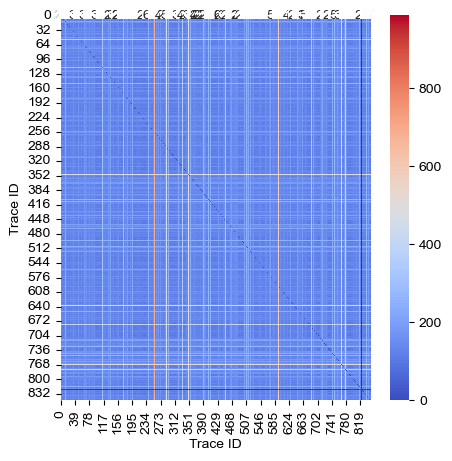

In [15]:
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 10 
})

fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(hamming_distance_matrix.astype(float), annot=True, cmap='coolwarm', fmt='g')

#plt.title('Heatmap of Hamming Distance Matrix', fontsize=12, fontweight='bold')
plt.xlabel('Trace ID', fontsize=10)
plt.ylabel('Trace ID', fontsize=10)
plt.savefig('eFigure1_Heatmap of Hamming Distance Matrix.png', format='png', dpi=300)
plt.show()

In [16]:
levenshtein_distance_matrix = pd.DataFrame(index=range(num_elements), columns=range(num_elements))


for i in range(num_elements):
    for j in range(num_elements):
        dist = levenshtein_distance(traces.at[i, "events"], traces.at[j, "events"])
        levenshtein_distance_matrix.at[i, j] = dist

print(levenshtein_distance_matrix)

     0    1    2    3    4    5    6    7    8    9    ...  837  838  839  \
0      0  108  101   97  114  100  112  106   95  116  ...  108  101  116   
1    108    0   98  102  120   92  110  100   87  120  ...  102  100  121   
2    101   98    0   97  106  101  114   96   91  117  ...  103  108  116   
3     97  102   97    0  114  101  109  105   92  124  ...  100  103  112   
4    114  120  106  114    0  119  129  112  112  128  ...  114  119  130   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
842  111  117  121  112  127  111  111  115  108  126  ...  116  113  113   
843  129  131  127  130  142  124  125  125  130  138  ...  123  130  130   
844  103   90  103   98  117   97  115   94   79  121  ...  107   93  117   
845  124  127  123  131  134  126  129  128  125  134  ...  127  120  134   
846   93   88   97   91  116   94  110   95   82  120  ...  102  103  116   

     840  841  842  843  844  845  846  
0    103  152  111  129  103  124 

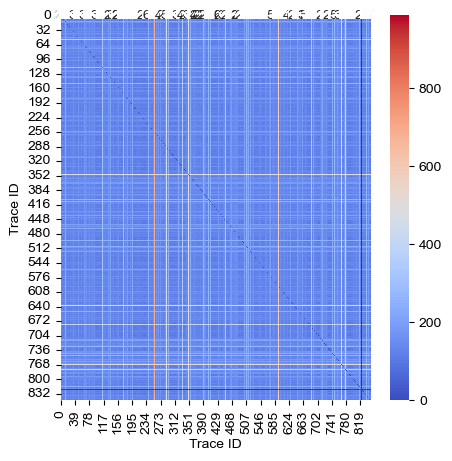

In [18]:

plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 10 
})

fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(hamming_distance_matrix.astype(float), annot=True, cmap='coolwarm', fmt='g')

#plt.title('Heatmap of Levenshtein Distance Matrix', fontsize=12, fontweight='bold')
plt.xlabel('Trace ID', fontsize=10)
plt.ylabel('Trace ID', fontsize=10)
plt.savefig('eFigure2_Heatmap of Levenshtein Distance Matrix.png', format='png', dpi=300)
plt.show()

In [19]:
levenshtein_row_averages = levenshtein_distance_matrix.mean(axis=1)

print("Levenshtein row averages:")
print(levenshtein_row_averages)

Levenshtein row averages:
0      119.049587
1      116.386068
2      118.491145
3      118.930342
4      130.230224
          ...    
842    131.514758
843    140.905549
844    113.433294
845    137.600945
846    114.541913
Length: 847, dtype: object


In [20]:
levenshtein_averages = levenshtein_row_averages.tolist()
levenshtein_averages = pd.DataFrame(levenshtein_row_averages, columns=['variation distance'])
print("Levenshtein averages:")
print(levenshtein_averages)

Levenshtein averages:
    variation distance
0           119.049587
1           116.386068
2           118.491145
3           118.930342
4           130.230224
..                 ...
842         131.514758
843         140.905549
844         113.433294
845         137.600945
846         114.541913

[847 rows x 1 columns]


In [21]:

levenshtein_sorted_row_averages = levenshtein_row_averages.sort_values(ascending=False)


levenshtein_reordered_matrix = levenshtein_distance_matrix.loc[levenshtein_sorted_row_averages.index]

print("Sorted row averages (descending):")
print(levenshtein_sorted_row_averages)

print("Reordered Levenshtein distance matrix:")
print(levenshtein_reordered_matrix)

Sorted row averages (descending):
822    889.116883
256    609.860685
450    592.735537
304    507.770956
595         501.0
          ...    
749    110.904368
497    110.877214
734    110.766234
17      110.64817
394    110.075561
Length: 847, dtype: object
Reordered Levenshtein distance matrix:
     0    1    2    3    4    5    6    7    8    9    ...  837  838  839  \
822  889  909  893  905  894  911  893  900  913  878  ...  889  891  890   
256  611  627  608  623  614  625  607  613  628  598  ...  607  612  614   
450  592  609  589  607  593  607  591  595  605  576  ...  591  590  594   
304  507  516  505  521  507  520  507  511  525  501  ...  503  507  509   
595  505  515  498  514  499  518  500  502  518  492  ...  497  499  501   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
749   89   89  100   87  115   87  110   90   79  112  ...   99   97  110   
497   93   83   90   88  111   87  111   88   79  115  ...   96  101  113   
734   92 

In [22]:
temp_distance = levenshtein_sorted_row_averages.reset_index(drop=True)

top_2_5_percentile = np.percentile(temp_distance, 97.5)
top_5_percentile = np.percentile(temp_distance, 95)
top_10_percentile = np.percentile(temp_distance, 90)
top_20_percentile = np.percentile(temp_distance, 80)
bottom_20_percentile = np.percentile(temp_distance, 20)

print(f"Top 2.5% of the list is above: {top_2_5_percentile}")
print(f"22 th: {levenshtein_sorted_row_averages[21]}")
print(f"Top 5% of the list is above: {top_5_percentile}")
print(f"Top 10% of the list is above: {top_10_percentile}")
print(f"Top 20% of the list is above: {top_20_percentile}")
print(f"Bottom 20% of the list is below: {bottom_20_percentile}")

Top 2.5% of the list is above: 221.14651711924438
22 th: 119.08972845336481
Top 5% of the list is above: 187.80047225501755
Top 10% of the list is above: 153.28429752066117
Top 20% of the list is above: 136.22337662337662
Bottom 20% of the list is below: 115.63022432113341


In [23]:
if not levenshtein_sorted_row_averages.index.equals(hamming_sorted_row_averages.index):
    levenshtein_sorted_row_averages_positions = pd.Series(levenshtein_sorted_row_averages.index, name='levenshtein_sorted_row_averages_index')
    hamming_sorted_row_averages_positions = pd.Series(hamming_sorted_row_averages.index, name='hamming_sorted_row_averages_index')

    comparison_df = pd.DataFrame({'levenshtein_sorted_row_averages_traceid': levenshtein_sorted_row_averages_positions, 'hamming_sorted_row_averages_traceid': hamming_sorted_row_averages_positions})
    mismatched_positions = comparison_df[levenshtein_sorted_row_averages_positions != hamming_sorted_row_averages_positions]
    display(comparison_df)  
    print("Mismatched trace id:")
    display(mismatched_positions)  
else:
    print("same trace id.")

,levenshtein_sorted_row_averages_traceid,hamming_sorted_row_averages_traceid
0,822,822
1,256,256
2,450,450
3,304,304
4,595,595
...,...,...
842,749,792
843,497,833
844,734,148
845,17,563


Mismatched trace id:


,levenshtein_sorted_row_averages_traceid,hamming_sorted_row_averages_traceid
18,157,114
19,114,460
20,460,157
21,170,172
22,172,170
...,...,...
842,749,792
843,497,833
844,734,148
845,17,563


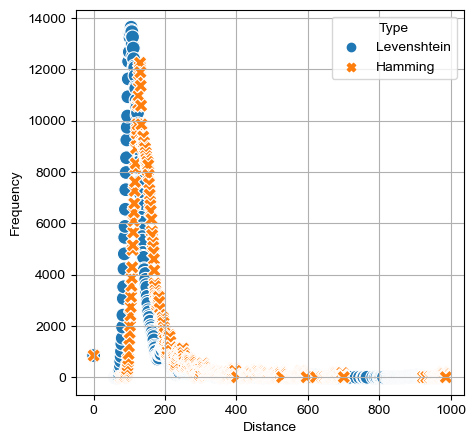

In [26]:
lev_distances = levenshtein_distance_matrix.values.flatten()
ham_distances = hamming_distance_matrix.values.flatten()

lev_unique_distances, lev_counts = np.unique(lev_distances, return_counts=True)
ham_unique_distances, ham_counts = np.unique(ham_distances, return_counts=True)

lev_distance_freq_df = pd.DataFrame({'Distance': lev_unique_distances, 'Frequency': lev_counts, 'Type': 'Levenshtein'})
ham_distance_freq_df = pd.DataFrame({'Distance': ham_unique_distances, 'Frequency': ham_counts, 'Type': 'Hamming'})

distance_freq_df = pd.concat([lev_distance_freq_df, ham_distance_freq_df])


plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 10 
})

fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(data=distance_freq_df, x='Distance', y='Frequency', hue='Type', style='Type', s=100)

#plt.title('Frequency Distributions of Hamming and Levenshtein Distance Measurements', fontsize=12, fontweight='bold')
plt.xlabel('Distance', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.savefig('eFigure3_Frequency Distributions of Hamming and Levenshtein Distance Measurements.png', bbox_inches='tight',format='png', dpi=300)
plt.grid(True)
plt.show()

In [27]:
#Select the top 2.5% and bottom 2.5% lists
top_2_percent_index = int(np.ceil(len(levenshtein_sorted_row_averages) * 0.025))
bottom_2_percent_index = int(np.floor(len(levenshtein_sorted_row_averages) * 0.975))

top_2_percent_lists = levenshtein_reordered_matrix.iloc[:top_2_percent_index]
bottom_2_percent_lists = levenshtein_reordered_matrix.iloc[bottom_2_percent_index:]

In [28]:
# Select the top 5% and bottom 5% lists
top_5_percent_index = int(np.ceil(len(levenshtein_sorted_row_averages) * 0.05))
bottom_5_percent_index = int(np.floor(len(levenshtein_sorted_row_averages) * 0.95))

top_5_percent_lists = levenshtein_reordered_matrix.iloc[:top_5_percent_index]
bottom_5_percent_lists = levenshtein_reordered_matrix.iloc[bottom_5_percent_index:]

In [29]:
# Select the top 10% and bottom 10% lists
top_10_percent_index = int(np.ceil(len(levenshtein_sorted_row_averages) * 0.10))
bottom_10_percent_index = int(np.floor(len(levenshtein_sorted_row_averages) * 0.90))

top_10_percent_lists = levenshtein_reordered_matrix.iloc[:top_10_percent_index]
bottom_10_percent_lists = levenshtein_reordered_matrix.iloc[bottom_10_percent_index:]

In [30]:
# Select the top 20% and bottom 20% lists
top_20_percent_index = int(np.ceil(len(levenshtein_sorted_row_averages) * 0.20))
bottom_20_percent_index = int(np.floor(len(levenshtein_sorted_row_averages) * 0.80))

top_20_percent_lists = levenshtein_reordered_matrix.iloc[:top_20_percent_index]
bottom_20_percent_lists = levenshtein_reordered_matrix.iloc[bottom_20_percent_index:]

In [31]:
print("Top 2.5% lists:")
print(top_2_percent_lists)
print("Bottom 2.5% lists:")
print(bottom_2_percent_lists)

top_2_percent_index = top_2_percent_lists.index.tolist()
print("PatientID of Top 2.5% traces:")
print(top_2_percent_lists.index.tolist())
bottom_2_percent_index = bottom_2_percent_lists.index.tolist()
print("PatientID of Bottom 2.5% traces:")
print(bottom_2_percent_lists.index.tolist())

Top 2.5% lists:
     0    1    2    3    4    5    6    7    8    9    ...  837  838  839  \
822  889  909  893  905  894  911  893  900  913  878  ...  889  891  890   
256  611  627  608  623  614  625  607  613  628  598  ...  607  612  614   
450  592  609  589  607  593  607  591  595  605  576  ...  591  590  594   
304  507  516  505  521  507  520  507  511  525  501  ...  503  507  509   
595  505  515  498  514  499  518  500  502  518  492  ...  497  499  501   
767  443  458  442  452  441  455  439  443  458  431  ...  437  435  443   
349  404  423  404  415  403  422  404  408  421  398  ...  405  406  405   
384  389  402  394  400  396  405  389  393  401  382  ...  392  394  393   
289  370  390  377  389  372  389  375  379  390  369  ...  374  378  377   
638  373  379  371  379  370  380  371  368  383  362  ...  363  368  369   
679  321  326  316  328  327  330  323  322  334  319  ...  316  318  324   
778  314  331  314  329  320  326  318  322  333  314  ...  

In [32]:
complete_patients_clinical = pd.read_csv('completepatients.csv')
complete_patients = pd.concat([complete_patients_clinical,levenshtein_averages], axis=1)
print(complete_patients.head())

   subject_id   hadm_id  age gender insurance language                race  \
0    10002013  23581541   57      F  Medicare  ENGLISH               OTHER   
1    10011398  27505812   67      M     Other  ENGLISH  HISPANIC OR LATINO   
2    10023771  20044587   70      M  Medicare  ENGLISH               WHITE   
3    10033786  27383470   50      M     Other  ENGLISH               WHITE   
4    10039688  26345871   63      F  Medicare  ENGLISH               WHITE   

  marital_status  myocardial_infarct  congestive_heart_failure  ...  \
0         SINGLE                   1                         1  ...   
1        MARRIED                   0                         0  ...   
2        MARRIED                   0                         0  ...   
3        MARRIED                   0                         0  ...   
4        MARRIED                   1                         0  ...   

   renal_disease  malignant_cancer  severe_liver_disease  \
0              0                 0          

In [33]:
characteristics_table = pd.DataFrame({
    "Variable": ["Total patients", "Age, mean (SD)", "Gender (Female)", 
                 "Insurance (Medicare)", "Language (English)", "Race (White)", 
                 "Marital Status (Married)", "Charlson Comorbidity Index, mean (SD)", 
                 "In hospital mortality", "Died within 30 days", "Length of stay, mean (SD)"],
    "No. (%)": [
        len(complete_patients_clinical),  # Total patients
        f"{complete_patients_clinical['age'].mean():.1f} ({complete_patients_clinical['age'].std():.1f})",  
        f"{(complete_patients_clinical['gender'] == 'F').sum()} ({(complete_patients_clinical['gender'] == 'F').mean() * 100:.1f}%)", 
        f"{(complete_patients_clinical['insurance'] == 'Medicare').sum()} ({(complete_patients_clinical['insurance'] == 'Medicare').mean() * 100:.1f}%)",  
        f"{(complete_patients_clinical['language'] == 'ENGLISH').sum()} ({(complete_patients_clinical['language'] == 'ENGLISH').mean() * 100:.1f}%)",  
        f"{(complete_patients_clinical['race'] == 'WHITE').sum()} ({(complete_patients_clinical['race'] == 'WHITE').mean() * 100:.1f}%)",  
        f"{(complete_patients_clinical['marital_status'] == 'MARRIED').sum()} ({(complete_patients_clinical['marital_status'] == 'MARRIED').mean() * 100:.1f}%)",  
        f"{complete_patients_clinical['cci'].mean():.1f} ({complete_patients_clinical['cci'].std():.1f})",  
        f"{complete_patients_clinical['in_hospital_mortality'].sum()} ({complete_patients_clinical['in_hospital_mortality'].mean() * 100:.1f}%)",  
        f"{complete_patients_clinical['died_within_30_days'].sum()} ({complete_patients_clinical['died_within_30_days'].mean() * 100:.1f}%)",  
        f"{complete_patients_clinical['length_of_stay'].mean():.1f} ({complete_patients_clinical['length_of_stay'].std():.1f})"  
    ]
})
print(characteristics_table)

                                 Variable       No. (%)
0                          Total patients           847
1                          Age, mean (SD)    65.9 (9.7)
2                         Gender (Female)   146 (17.2%)
3                    Insurance (Medicare)   313 (37.0%)
4                      Language (English)   773 (91.3%)
5                            Race (White)   642 (75.8%)
6                Marital Status (Married)   600 (70.8%)
7   Charlson Comorbidity Index, mean (SD)     3.8 (2.0)
8                   In hospital mortality      7 (0.8%)
9                     Died within 30 days      9 (1.1%)
10              Length of stay, mean (SD)  140.0 (72.9)


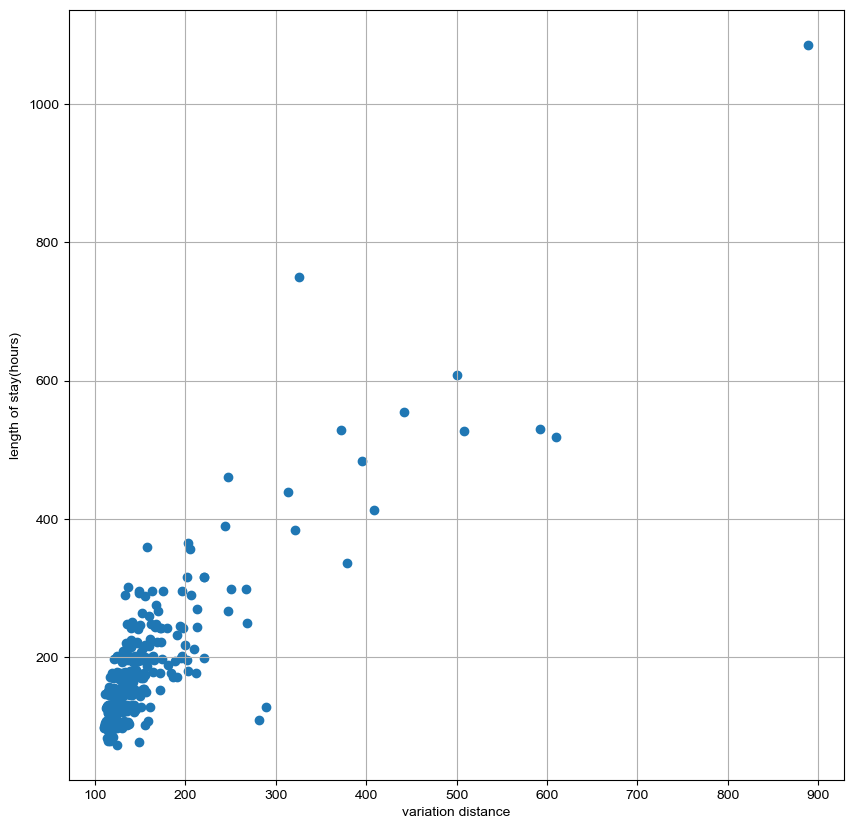

In [36]:


plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 10 
})

fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(complete_patients['variation distance'],complete_patients['length_of_stay'])

#plt.title('Relationship Between Variation and Length of Stay', fontsize=12, fontweight='bold')
plt.xlabel('variation distance', fontsize=10)
plt.ylabel('length of stay(hours)', fontsize=10)
plt.savefig('Figure_Relationship Between Variation and Length of Stay.png', bbox_inches='tight',format='png', dpi=800)
plt.grid(True)
plt.show()

In [37]:
#print(complete_patients.dtypes)
complete_patients['distance'] = pd.to_numeric(complete_patients['variation distance'], errors='coerce')

In [38]:
complete_patients['age_group'] = pd.cut(complete_patients['age'], bins=[20, 30, 40, 50, 60, 70, 80, 90, 100],
                         labels=['20-30', '31-40', '41-50', '51-60', '61-70','71-80','81-90','91-100'])

In [39]:
def categorize_cci(cci):
    if 10 <= cci <= 12:
        return '10-12'
    elif 8 <= cci < 10:
        return '8-10'
    elif 6 <= cci < 8:
        return '6-8'
    elif 4 <= cci < 6:  
        return '4-6'
    elif 2 <= cci < 4:  
        return '2-4'
    elif 0 <= cci < 2:
        return '0-2'
complete_patients['cci_group'] = complete_patients['cci'].apply(categorize_cci)

In [40]:
def categorize_distance(distance):
    if distance >= 137:  
        return 'top20%'
    else:  
        return 'Other'
complete_patients['distance_group'] = complete_patients['distance'].apply(categorize_distance)

In [41]:
print(complete_patients.head())
#complete_patients.to_csv('test.csv',index = False)
value_counts = complete_patients['distance_group'].value_counts()
print(value_counts)

   subject_id   hadm_id  age gender insurance language                race  \
0    10002013  23581541   57      F  Medicare  ENGLISH               OTHER   
1    10011398  27505812   67      M     Other  ENGLISH  HISPANIC OR LATINO   
2    10023771  20044587   70      M  Medicare  ENGLISH               WHITE   
3    10033786  27383470   50      M     Other  ENGLISH               WHITE   
4    10039688  26345871   63      F  Medicare  ENGLISH               WHITE   

  marital_status  myocardial_infarct  congestive_heart_failure  ...  aids  \
0         SINGLE                   1                         1  ...     0   
1        MARRIED                   0                         0  ...     0   
2        MARRIED                   0                         0  ...     0   
3        MARRIED                   0                         0  ...     0   
4        MARRIED                   1                         0  ...     0   

   cci  in_hospital_mortality  died_within_30_days  length_of_stay  

In [42]:
complete_patients['race'] = complete_patients['race'].str.split(' ').str[0]
complete_patients['race']= complete_patients['race'].replace(['BLACK/AFRICAN', 'BLACK/CARIBBEAN','BLACK/CAPE','HISPANIC/LATINO','HISPANIC','PATIENT', 'UNABLE','SOUTH','PORTUGUESE','MULTIPLE','OTHER','ASIAN','UNKNOWN'], 'OTHER')
value_counts_race = complete_patients['race'].value_counts()
print(value_counts_race)

race
WHITE    667
OTHER    180
Name: count, dtype: int64


In [43]:
value_counts_gender = complete_patients['gender'].value_counts()
print(value_counts_gender)
value_counts_insurance = complete_patients['insurance'].value_counts()
print(value_counts_insurance)

gender
M    701
F    146
Name: count, dtype: int64
insurance
Other       506
Medicare    313
Medicaid     28
Name: count, dtype: int64


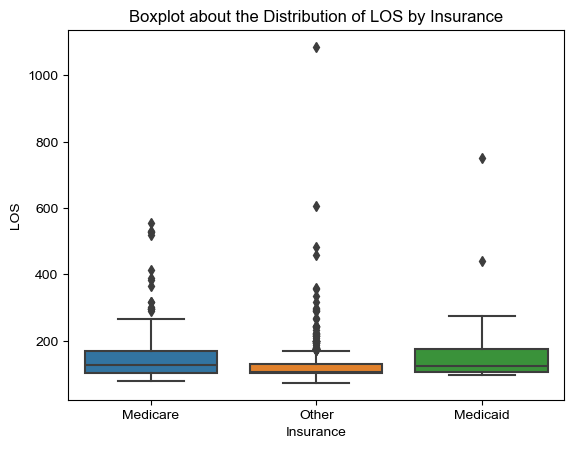

In [44]:
sns.boxplot(x='insurance', y='length_of_stay', data=complete_patients[['insurance','length_of_stay']])
plt.title('Boxplot about the Distribution of LOS by Insurance')
plt.xlabel('Insurance')
plt.ylabel('LOS')
plt.show()

In [45]:
import statsmodels.formula.api as smf
y = complete_patients['length_of_stay']
model = smf.ols('y ~ distance_group + age + cci + C(gender) + C(insurance) + C(race)', data=complete_patients).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     75.57
Date:                Tue, 18 Feb 2025   Prob (F-statistic):           8.79e-85
Time:                        12:07:21   Log-Likelihood:                -4627.6
No. Observations:                 847   AIC:                             9271.
Df Residuals:                     839   BIC:                             9309.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [46]:
print(complete_patients.columns)

Index(['subject_id', 'hadm_id', 'age', 'gender', 'insurance', 'language',
       'race', 'marital_status', 'myocardial_infarct',
       'congestive_heart_failure', 'peripheral_vascular_disease',
       'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease',
       'rheumatic_disease', 'peptic_ulcer_disease', 'mild_liver_disease',
       'diabetes_without_cc', 'diabetes_with_cc', 'paraplegia',
       'renal_disease', 'malignant_cancer', 'severe_liver_disease',
       'metastatic_solid_tumor', 'aids', 'cci', 'in_hospital_mortality',
       'died_within_30_days', 'length_of_stay', 'variation distance',
       'distance', 'age_group', 'cci_group', 'distance_group'],
      dtype='object')


In [47]:
top_2_percent = complete_patients.loc[top_2_percent_index]
print(top_2_percent)
output_path = 'top_2_percent.csv'
top_2_percent.to_csv(output_path, index=False)
top_2_percent_los = top_2_percent['length_of_stay'].mean()
print(f"The average of LOS is: {top_2_percent_los}")
top_2_percent_in_hospital_mortality = top_2_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {top_2_percent_in_hospital_mortality}")
top_2_percent_30_day_mortality = top_2_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {top_2_percent_30_day_mortality}")
top_2_percent_cci =top_2_percent['cci'].mean()
print(f"The average of CCI is: {top_2_percent_cci}")
top_2_percent_top3cci_averages = top_2_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
top_2_percent_top3cci = top_2_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(top_2_percent_top3cci)

     subject_id   hadm_id  age gender insurance language   race  \
822    19723798  26593663   52      M     Other  ENGLISH  WHITE   
256    13365915  29277897   82      M  Medicare  ENGLISH  WHITE   
450    15520282  23427760   72      M  Medicare  ENGLISH  WHITE   
304    13994771  25043633   81      F  Medicare  ENGLISH  WHITE   
595    17033046  21582058   82      M     Other  ENGLISH  WHITE   
767    19177655  29636680   80      M  Medicare  ENGLISH  WHITE   
349    14369707  20575513   75      F  Medicare  ENGLISH  WHITE   
384    14795403  29574331   57      M     Other  ENGLISH  WHITE   
289    13772495  24349829   75      M     Other  ENGLISH  WHITE   
638    17587573  20290742   83      M  Medicare  ENGLISH  WHITE   
679    17996934  24047037   61      F  Medicaid  ENGLISH  WHITE   
778    19359798  25190591   72      M  Medicare  ENGLISH  WHITE   
52     10710573  29923776   55      M  Medicaid        ?  OTHER   
333    14195255  27013153   74      M  Medicare  ENGLISH  WHIT

In [48]:
# Display the top 5% lists
print("Top 5% lists:")
print(top_5_percent_lists)

# Display the bottom 5% lists
print("Bottom 5% lists:")
print(bottom_5_percent_lists)

top_5_percent_index = top_5_percent_lists.index.tolist()
print("PatientID of Top 5% traces:")
print(top_5_percent_lists.index.tolist())
bottom_5_percent_index = bottom_5_percent_lists.index.tolist()
print("PatientID of Bottom 5% traces:")
print(bottom_5_percent_lists.index.tolist())

Top 5% lists:
     0    1    2    3    4    5    6    7    8    9    ...  837  838  839  \
822  889  909  893  905  894  911  893  900  913  878  ...  889  891  890   
256  611  627  608  623  614  625  607  613  628  598  ...  607  612  614   
450  592  609  589  607  593  607  591  595  605  576  ...  591  590  594   
304  507  516  505  521  507  520  507  511  525  501  ...  503  507  509   
595  505  515  498  514  499  518  500  502  518  492  ...  497  499  501   
767  443  458  442  452  441  455  439  443  458  431  ...  437  435  443   
349  404  423  404  415  403  422  404  408  421  398  ...  405  406  405   
384  389  402  394  400  396  405  389  393  401  382  ...  392  394  393   
289  370  390  377  389  372  389  375  379  390  369  ...  374  378  377   
638  373  379  371  379  370  380  371  368  383  362  ...  363  368  369   
679  321  326  316  328  327  330  323  322  334  319  ...  316  318  324   
778  314  331  314  329  320  326  318  322  333  314  ...  31

In [49]:
# Display the top 10% lists
print("Top 10% lists:")
print(top_10_percent_lists)

# Display the bottom 10% lists
print("Bottom 10% lists:")
print(bottom_10_percent_lists)

top_10_percent_index = top_10_percent_lists.index.tolist()
print("PatientID of Top 10% traces:")
print(top_10_percent_lists.index.tolist())
bottom_10_percent_index = bottom_10_percent_lists.index.tolist()
print("PatientID of Bottom 10% traces:")
print(bottom_10_percent_lists.index.tolist())

Top 10% lists:
     0    1    2    3    4    5    6    7    8    9    ...  837  838  839  \
822  889  909  893  905  894  911  893  900  913  878  ...  889  891  890   
256  611  627  608  623  614  625  607  613  628  598  ...  607  612  614   
450  592  609  589  607  593  607  591  595  605  576  ...  591  590  594   
304  507  516  505  521  507  520  507  511  525  501  ...  503  507  509   
595  505  515  498  514  499  518  500  502  518  492  ...  497  499  501   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
123  135  149  136  141  152  146  144  145  148  146  ...  143  146  150   
647  141  144  146  149  155  140  150  141  140  149  ...  148  141  152   
628  143  146  135  147  139  153  146  144  146  154  ...  139  137  154   
756  141  147  140  145  147  150  140  146  143  142  ...  144  131  151   
544  148  142  142  148  145  140  150  147  146  152  ...  142  137  151   

     840  841  842  843  844  845  846  
822  897  850  892 

In [50]:
# Display the top 20% lists
print("Top 20% lists:")
print(top_20_percent_lists)

# Display the bottom 20% lists
print("Bottom 20% lists:")
print(bottom_20_percent_lists)

top_20_percent_index = top_20_percent_lists.index.tolist()
print("PatientID of Top 20% traces:")
print(top_20_percent_lists.index.tolist())
bottom_20_percent_index = bottom_20_percent_lists.index.tolist()
print("PatientID of Bottom 20% traces:")
print(bottom_20_percent_lists.index.tolist())

Top 20% lists:
     0    1    2    3    4    5    6    7    8    9    ...  837  838  839  \
822  889  909  893  905  894  911  893  900  913  878  ...  889  891  890   
256  611  627  608  623  614  625  607  613  628  598  ...  607  612  614   
450  592  609  589  607  593  607  591  595  605  576  ...  591  590  594   
304  507  516  505  521  507  520  507  511  525  501  ...  503  507  509   
595  505  515  498  514  499  518  500  502  518  492  ...  497  499  501   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
808  128  125  124  128  126  127  127  118  119  127  ...  124  115  127   
378  122  123  117  128  130  122  134  120  119  136  ...  128  123  139   
787  124  128  116  119  129  129  123  117  119  127  ...  122  121  128   
35   124  119  119  119  126  121  131  118  120  124  ...  119  125  133   
328  120  116  117  124  125  124  129  121  114  130  ...  124  121  132   

     840  841  842  843  844  845  846  
822  897  850  892 

In [51]:
top_5_percent = complete_patients.loc[top_5_percent_index]
output_path = 'top_5_percent.csv'
top_5_percent.to_csv(output_path, index=False)
top_5_percent_los = top_5_percent['length_of_stay'].mean()
print(f"The average of LOS is: {top_5_percent_los}")
top_5_percent_in_hospital_mortality = top_5_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {top_5_percent_in_hospital_mortality}")
top_5_percent_30_day_mortality = top_5_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {top_5_percent_30_day_mortality}")
top_5_percent_cci =top_5_percent['cci'].mean()
print(f"The average of CCI is: {top_5_percent_cci}")
top_5_percent_top3cci_averages = top_5_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
top_5_percent_top3cci = top_5_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(top_5_percent_top3cci)

The average of LOS is: 343.80620155038764
The average of in_hospital_mortality is: 0.13953488372093023
The average of 30_day_mortality is: 0.13953488372093023
The average of CCI is: 5.395348837209302
Top3 CCI:
diabetes_without_cc            0.395349
peripheral_vascular_disease    0.348837
chronic_pulmonary_disease      0.348837
dtype: float64


In [52]:
top_10_percent = complete_patients.loc[top_10_percent_index]
output_path = 'top_10_percent.csv'
top_10_percent.to_csv(output_path, index=False)
top_10_percent_los = top_10_percent['length_of_stay'].mean()
print(f"The average of LOS is: {top_10_percent_los}")
top_10_percent_in_hospital_mortality = top_10_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {top_10_percent_in_hospital_mortality}")
top_10_percent_30_day_mortality = top_10_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {top_10_percent_30_day_mortality}")
top_10_percent_cci =top_10_percent['cci'].mean()
print(f"The average of CCI is: {top_10_percent_cci}")
top_10_percent_top3cci_averages = top_10_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
top_10_percent_top3cci = top_10_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(top_10_percent_top3cci)

The average of LOS is: 277.5278431372549
The average of in_hospital_mortality is: 0.07058823529411765
The average of 30_day_mortality is: 0.07058823529411765
The average of CCI is: 5.364705882352941
Top3 CCI:
diabetes_without_cc          0.411765
chronic_pulmonary_disease    0.352941
renal_disease                0.329412
dtype: float64


In [53]:
top_20_percent = complete_patients.loc[top_20_percent_index]
output_path = 'top_20_percent.csv'
top_20_percent.to_csv(output_path, index=False)
top_20_percent_los = top_20_percent['length_of_stay'].mean()
print(f"The average of LOS is: {top_20_percent_los}")
top_20_percent_in_hospital_mortality = top_20_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {top_20_percent_in_hospital_mortality}")
top_20_percent_30_day_mortality = top_20_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {top_20_percent_30_day_mortality}")
top_20_percent_cci =top_20_percent['cci'].mean()
print(f"The average of CCI is: {top_20_percent_cci}")
top_20_percent_top3cci_averages = top_20_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
top_20_percent_top3cci = top_20_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(top_20_percent_top3cci)

The average of LOS is: 226.12666666666667
The average of in_hospital_mortality is: 0.041176470588235294
The average of 30_day_mortality is: 0.041176470588235294
The average of CCI is: 4.91764705882353
Top3 CCI:
diabetes_without_cc          0.364706
myocardial_infarct           0.300000
chronic_pulmonary_disease    0.282353
dtype: float64


In [54]:
bottom_5_percent = complete_patients.loc[bottom_5_percent_index]
output_path = 'bottom_5_percent.csv'
bottom_5_percent.to_csv(output_path, index=False)
bottom_5_percent_los = bottom_5_percent['length_of_stay'].mean()
print(f"The average of LOS is: {bottom_5_percent_los}")
bottom_5_percent_in_hospital_mortality = bottom_5_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {bottom_5_percent_in_hospital_mortality}")
bottom_5_percent_30_day_mortality = bottom_5_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {bottom_5_percent_30_day_mortality}")
bottom_5_percent_cci =bottom_5_percent['cci'].mean()
print(f"The average of CCI is: {bottom_5_percent_cci}")

bottom_5_percent_top3cci_averages = bottom_5_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
bottom_5_percent_top3cci = bottom_5_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(bottom_5_percent_top3cci)

The average of LOS is: 105.53720930232556
The average of in_hospital_mortality is: 0.0
The average of 30_day_mortality is: 0.0
The average of CCI is: 3.3255813953488373
Top3 CCI:
diabetes_without_cc         0.325581
myocardial_infarct          0.209302
congestive_heart_failure    0.139535
dtype: float64


In [55]:
bottom_10_percent = complete_patients.loc[bottom_10_percent_index]
output_path = 'bottom_10_percent.csv'
bottom_10_percent.to_csv(output_path, index=False)
bottom_10_percent_los = bottom_10_percent['length_of_stay'].mean()
print(f"The average of LOS is: {bottom_10_percent_los}")
bottom_10_percent_in_hospital_mortality = bottom_10_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {bottom_10_percent_in_hospital_mortality}")
bottom_10_percent_30_day_mortality = bottom_10_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {bottom_10_percent_30_day_mortality}")
bottom_10_percent_cci =bottom_10_percent['cci'].mean()
print(f"The average of CCI is: {bottom_10_percent_cci}")

bottom_10_percent_top3cci_averages = bottom_10_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
bottom_10_percent_top3cci = bottom_10_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(bottom_10_percent_top3cci)

The average of LOS is: 107.718431372549
The average of in_hospital_mortality is: 0.0
The average of 30_day_mortality is: 0.0
The average of CCI is: 3.1411764705882352
Top3 CCI:
diabetes_without_cc          0.270588
myocardial_infarct           0.200000
chronic_pulmonary_disease    0.117647
dtype: float64


In [56]:
bottom_20_percent = complete_patients.loc[bottom_20_percent_index]
output_path = 'bottom_20_percent.csv'
bottom_20_percent.to_csv(output_path, index=False)
bottom_20_percent_los = bottom_20_percent['length_of_stay'].mean()
print(f"The average of LOS is: {bottom_20_percent_los}")
bottom_20_percent_in_hospital_mortality = bottom_20_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {bottom_20_percent_in_hospital_mortality}")
bottom_20_percent_30_day_mortality = bottom_20_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {bottom_20_percent_30_day_mortality}")
bottom_20_percent_cci =bottom_20_percent['cci'].mean()
print(f"The average of CCI is: {bottom_20_percent_cci}")

bottom_20_percent_top3cci_averages = bottom_20_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
bottom_20_percent_top3cci = bottom_20_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(bottom_20_percent_top3cci)

The average of LOS is: 106.0448039215686
The average of in_hospital_mortality is: 0.0
The average of 30_day_mortality is: 0.0
The average of CCI is: 2.9058823529411764
Top3 CCI:
diabetes_without_cc          0.270588
myocardial_infarct           0.205882
chronic_pulmonary_disease    0.088235
dtype: float64


In [57]:
#X = complete_patients[['age','cci','myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']]

In [58]:
traces_top_2_percent = traces.iloc[top_2_percent_index]
top_2_percent_patient = traces_top_2_percent['patientid']
print(top_2_percent_patient)
events_final_top_2_percent = events_final[events_final['patientid'].isin(top_2_percent_patient)]
print(events_final_top_2_percent)
events_final_top_2_percent.to_csv('events_final_top_2_percent.csv', index=False)

822    19723798
256    13365915
450    15520282
304    13994771
595    17033046
767    19177655
349    14369707
384    14795403
289    13772495
638    17587573
679    17996934
778    19359798
52     10710573
333    14195255
364    14603993
80     11076206
685    18083865
498    16035306
157    12109233
114    11464841
460    15610823
170    12253915
Name: patientid, dtype: int64
        patientid       events           starttime
7386     10710573        CSURG 2114-04-17 01:33:36
7387     10710573          ABG 2114-04-17 08:26:00
7388     10710573          CBC 2114-04-17 08:26:00
7389     10710573      Glucose 2114-04-17 08:26:00
7390     10710573      Calcium 2114-04-17 08:26:00
...           ...          ...                 ...
124294   19723798      Glucose 2151-01-26 01:30:00
124295   19723798   Creatinine 2151-01-26 01:30:00
124296   19723798  Bicarbonate 2151-01-26 01:30:00
124297   19723798   Ranitidine 2151-01-26 08:00:00
124298   19723798    Lorazepam 2151-01-26 12:00:00

[1009

In [59]:
traces_top_5_percent = traces.iloc[top_5_percent_index]
top_5_percent_patient = traces_top_5_percent['patientid']
print(top_5_percent_patient)
events_final_top_5_percent = events_final[events_final['patientid'].isin(top_5_percent_patient)]
print(events_final_top_5_percent)
events_final_top_5_percent.to_csv('events_final_top_5_percent.csv', index=False)

822    19723798
256    13365915
450    15520282
304    13994771
595    17033046
767    19177655
349    14369707
384    14795403
289    13772495
638    17587573
679    17996934
778    19359798
52     10710573
333    14195255
364    14603993
80     11076206
685    18083865
498    16035306
157    12109233
114    11464841
460    15610823
170    12253915
172    12288757
149    12001282
404    14981236
748    18942549
728    18669132
835    19872834
12     10135595
383    14790760
495    16006577
508    16151940
390    14851532
651    17672672
295    13801654
449    15502607
816    19674244
240    13139482
743    18906801
409    15022453
468    15737972
355    14479229
395    14908025
Name: patientid, dtype: int64
        patientid                       events           starttime
1624     10135595                        CSURG 2122-04-01 00:11:48
1625     10135595                      Aspirin 2122-04-01 08:00:00
1626     10135595             Milk of Magnesia 2122-04-01 08:00:00
1627     10135

In [60]:
traces_bottom_20_percent = traces.iloc[bottom_20_percent_index]
bottom_20_percent_patient = traces_bottom_20_percent['patientid']
print(bottom_20_percent_patient)
events_final_bottom_20_percent = events_final[events_final['patientid'].isin(bottom_20_percent_patient)]
print(events_final_bottom_20_percent)
events_final_bottom_20_percent.to_csv('events_final_bottom_20_percent.csv', index=False)

291    13773889
320    14099980
732    18704055
554    16637031
212    12749443
         ...   
749    18948626
497    16019747
734    18716421
17     10204455
394    14884188
Name: patientid, Length: 170, dtype: int64
        patientid             events           starttime
1099     10063488              CSURG 2149-12-07 01:16:01
1100     10063488            Aspirin 2149-12-07 10:00:00
1101     10063488                ABG 2149-12-07 12:01:00
1102     10063488            Calcium 2149-12-07 12:01:00
1103     10063488            Glucose 2149-12-07 12:01:00
...           ...                ...                 ...
127841   19995790  Magnesium Sulfate 2185-02-05 01:00:00
127842   19995790         Metoprolol 2185-02-05 20:00:00
127843   19995790  Magnesium Sulfate 2185-02-06 02:00:00
127844   19995790       Electrolytes 2185-02-06 06:00:00
127845   19995790         Metoprolol 2185-02-06 20:00:00

[19069 rows x 3 columns]
